In [25]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [26]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle
import gc
import re
import itertools

import numpy as np
import pandas as pd

from importlib import reload

import scipy.sparse

import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data
from helpers import train_model

### Load validation predicted probabilities

In [28]:
main_dir = '/tf/notebooks/'

In [29]:
probs_path = main_dir+'final-project/Classification/data/party'

In [30]:
test_pred_probs_mlp_ngram = np.load(os.path.join(probs_path, 'test_pred_probs_mlp_ngram.npy'))
test_pred_probs_cnn = np.load(os.path.join(probs_path, 'test_pred_probs_cnn.npy'))
test_pred_probs_cnn_aggr_chunk = np.load(os.path.join(probs_path, 'test_pred_probs_cnn_aggr_chunk.npy'))

In [31]:
len(test_pred_probs_mlp_ngram), len(test_pred_probs_cnn), len(test_pred_probs_cnn_aggr_chunk)

(101154, 101154, 101154)

In [32]:
with open(os.path.join(probs_path, 'test_ids'), 'rb') as fp:
    test_ids = pickle.load(fp)
with open(os.path.join(probs_path, 'test_target'), 'rb') as fp:
    test_target = pickle.load(fp)
with open(os.path.join(probs_path, 'test_list'), 'rb') as fp:
    test_list = pickle.load(fp)

In [33]:
len(test_ids), len(test_target), len(test_list)

(101154, 101154, 101154)

In [34]:
descr_df = pd.read_csv(main_dir+'final-project/data/QA/full_descr.txt', sep="|", index_col=0)
descr_df = descr_df.loc[np.asarray(test_ids, dtype=int)]
descr_df.reset_index(inplace=True)
# descr_df.drop_duplicates('speech_id', inplace=True)
descr_df.shape

(106168, 17)

In [35]:
pred_df = pd.DataFrame({'ids': np.asarray(test_ids, dtype=np.int64), 
                        'Party_model': np.asarray(test_target, dtype=np.int), 
                        'pred_probs_mlp_ngram': test_pred_probs_mlp_ngram.flatten(), 
                        'pred_probs_cnn': test_pred_probs_cnn.flatten(),
                        'pred_probs_cnn_chunk': test_pred_probs_cnn_aggr_chunk.flatten()})
pred_df.shape

(101154, 5)

In [36]:
descr_pred_df = descr_df.merge(pred_df, left_on='speech_id', right_on='ids')
descr_pred_df.drop_duplicates(['speech_id'], inplace=True)
descr_pred_df.reset_index(inplace=True)
descr_pred_df.shape

(101154, 23)

In [37]:
descr_pred_df.Party_model.value_counts()

1    53825
0    47329
Name: Party_model, dtype: int64

In [38]:
pd.crosstab(descr_pred_df.Party, descr_pred_df.Party_model)

Party_model,0,1
Party,,
D,386,53468
I,0,1
R,46943,356


In [39]:
party_dummy = []
for p in range(descr_pred_df.shape[0]):
    if descr_pred_df.Party[p] == 'D':
        party_dummy.append(1)
    else:
        party_dummy.append(0)
len(party_dummy)
descr_pred_df['Party_dummy'] = party_dummy

In [40]:
preds = [
    'pred_probs_mlp_ngram',
    'pred_probs_cnn', 
    'pred_probs_cnn_chunk'
]

In [41]:
descr_pred_df[preds+['Party']].groupby('Party').mean()

,pred_probs_mlp_ngram,pred_probs_cnn,pred_probs_cnn_chunk
Party,,,
D,0.632407,0.609240,0.574856
I,0.515586,0.575303,0.553232
R,0.387195,0.419822,0.484470


In [42]:
descr_pred_df[preds+['Party_dummy']].groupby('Party_dummy').mean()

,pred_probs_mlp_ngram,pred_probs_cnn,pred_probs_cnn_chunk
Party_dummy,,,
0,0.387198,0.419825,0.484472
1,0.632407,0.609240,0.574856


In [43]:
descr_pred_df['pred_probs_combo'] = descr_pred_df[preds].mean(axis=1)
descr_pred_df['pred_combo'] = descr_pred_df['pred_probs_combo'] > 0.5
np.mean(test_target==descr_pred_df['pred_combo'].values.flatten())

0.6977084445498942

### Save the main dataframe

In [44]:
keep_cols = ['speech_id',
 'date',
 'char_count',
 'word_count',
 'speakerid',
 'Party',
 'Congress',
 'Chamber',
 'State',
 'Ethnicity',
 'Age',
 'Age_lt_med',
 'NonWhite',
 'Female',
 'speaker',
 'Full Name',
 'match',
 'ids',
 'pred_probs_combo',
 'pred_combo']

In [45]:
descr_pred_df[keep_cols].to_pickle(os.path.join(probs_path, 'test_party_preds.pkl'))

### Evaluating final predictions

In [46]:
classes = ['Republican', 'Democrat']

Confusion matrix, without normalization
[[30919 16410]
 [14168 39657]]
              precision    recall  f1-score   support

  Republican       0.69      0.65      0.67     47329
    Democrat       0.71      0.74      0.72     53825

   micro avg       0.70      0.70      0.70    101154
   macro avg       0.70      0.70      0.70    101154
weighted avg       0.70      0.70      0.70    101154



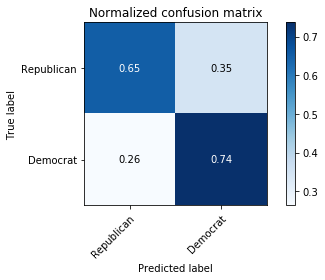

In [47]:
explore_data.plot_confusion_matrix(test_target, descr_pred_df['pred_combo'], classes, normalize=True)

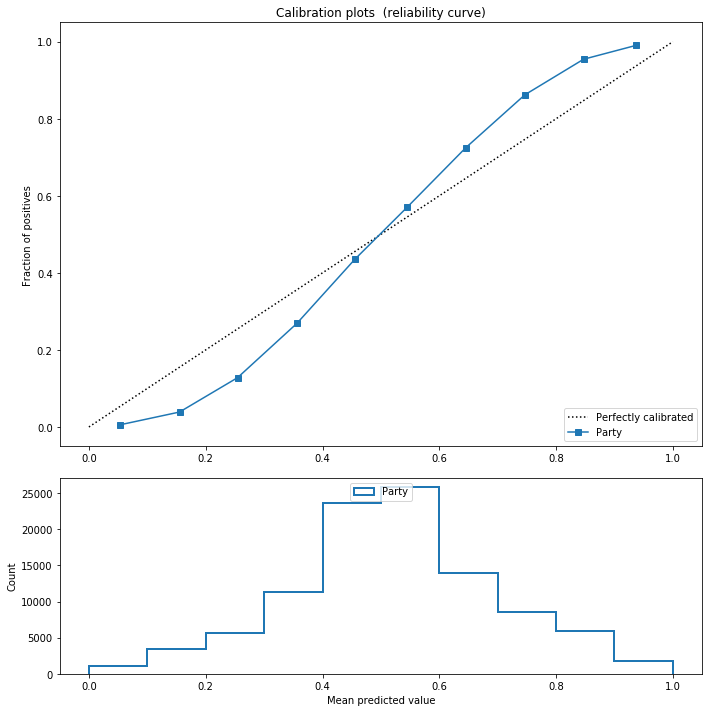

In [48]:
explore_data.plot_calibration_curve(test_target, descr_pred_df['pred_probs_combo'], 'Party')

In [49]:
reload(explore_data)
# checking the ratios of demo variables in low-mid-high probability buckets
explore_data.check_bin_probs_distr(descr_pred_df['pred_probs_combo'], 
                                   test_ids, 
                                   descr_df.set_index('speech_id'))

Validation sample means:
      Gender_F  Ethinicity_NW     AvgAge   Party_D  Chamber_H  AvgWordCount
base  0.092033       0.098787  57.688823  0.529039     0.6062     381.44163


,Gender_F,Ethinicity_NW,AvgAge,Party_D,Chamber_H,AvgWordCount
0.4,0.60,0.46,0.98,0.35,1.00,1.17
0.6,0.79,0.80,1.00,0.95,0.95,0.79
1.0,1.62,1.71,1.01,1.54,1.07,1.21


In [50]:
reload(explore_data)
explore_data.compare_ngrams(test_list, descr_pred_df['pred_probs_combo'], 
                            ngram_range=(1, 1),
                            top_k=20)


Top 20 ngrams by differentiating score:


,ngram,<0.4,<0.6,<1.0,score
0,republican,2251.0,2610.0,8080.0,855.0
1,spending,9487.0,4192.0,4302.0,792.0
2,taxes,6293.0,2264.0,2269.0,731.0
3,families,3938.0,4391.0,9428.0,720.0
4,women,2571.0,4734.0,9729.0,496.0
5,lives,2279.0,3772.0,5480.0,495.0
6,spend,3255.0,2036.0,1877.0,493.0
7,republicans,1914.0,1475.0,4641.0,488.0
8,tax,15531.0,8771.0,12679.0,450.0
9,education,4113.0,6138.0,11399.0,430.0


## Congressperson level analysis

In [51]:
speaker_df = descr_pred_df[['Full Name', 'Party_dummy', 'State', 'Female', 'NonWhite', 'Age', 'pred_probs_combo']]\
                .groupby(['Full Name', 'Party_dummy', 'State', 'Female', 'NonWhite'])\
                .agg({'pred_probs_combo':['mean', 'count'], 'Age': ['mean']})\
                .reset_index()
speaker_df.columns = ['_'.join(col) for col in speaker_df.columns]
speaker_df['Party_pred_'] = speaker_df.pred_probs_combo_mean > 0.5
speaker_df.shape

(1778, 9)

Confusion matrix, without normalization
[[728 167]
 [ 61 822]]
              precision    recall  f1-score   support

  Republican       0.92      0.81      0.86       895
    Democrat       0.83      0.93      0.88       883

   micro avg       0.87      0.87      0.87      1778
   macro avg       0.88      0.87      0.87      1778
weighted avg       0.88      0.87      0.87      1778



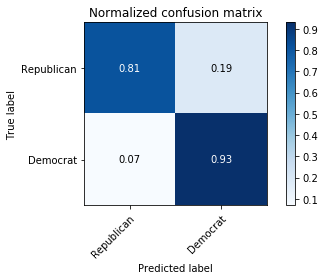

In [52]:
explore_data.plot_confusion_matrix(speaker_df.Party_dummy_, speaker_df.Party_pred_, classes, normalize=True)

In [53]:
speaker_df.pred_probs_combo_count.median()

26.0

In [54]:
speaker_med_df = speaker_df[speaker_df.pred_probs_combo_count > speaker_df.pred_probs_combo_count.median()]
speaker_med_df.shape

(871, 9)

Confusion matrix, without normalization
[[358  57]
 [  7 449]]
              precision    recall  f1-score   support

  Republican       0.98      0.86      0.92       415
    Democrat       0.89      0.98      0.93       456

   micro avg       0.93      0.93      0.93       871
   macro avg       0.93      0.92      0.93       871
weighted avg       0.93      0.93      0.93       871



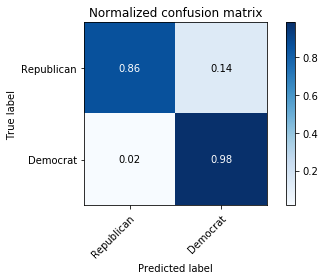

In [55]:
explore_data.plot_confusion_matrix(speaker_med_df.Party_dummy_, speaker_med_df.Party_pred_, classes, normalize=True)

In [56]:
tp = np.argmax(speaker_med_df[speaker_med_df.Party_dummy_==1].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.Party_dummy_==1].iloc[tp]

Full Name_                PERLMUTTER, ED
Party_dummy_                           1
State_                                CO
Female_                                0
NonWhite_                              0
Age_mean                         58.9785
pred_probs_combo_mean           0.829016
pred_probs_combo_count                93
Party_pred_                         True
Name: 1289, dtype: object

In [57]:
tn = np.argmin(speaker_med_df[speaker_med_df.Party_dummy_==0].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.Party_dummy_==0].iloc[tn]

Full Name_                GRAVES, SAM
Party_dummy_                        0
State_                             MO
Female_                             0
NonWhite_                           0
Age_mean                       45.885
pred_probs_combo_mean         0.10719
pred_probs_combo_count            113
Party_pred_                     False
Name: 665, dtype: object

In [58]:
fp = np.argmax(speaker_med_df[speaker_med_df.Party_dummy_==0].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.Party_dummy_==0].iloc[fp]

Full Name_                CAPITO, SHELLEY
Party_dummy_                            0
State_                                 WV
Female_                                 1
NonWhite_                               0
Age_mean                          55.7442
pred_probs_combo_mean            0.601958
pred_probs_combo_count                 43
Party_pred_                          True
Name: 252, dtype: object

In [59]:
fn = np.argmin(speaker_med_df[speaker_med_df.Party_dummy_==1].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.Party_dummy_==1].iloc[fn]

Full Name_                RAY, RICHARD
Party_dummy_                         1
State_                              GA
Female_                              0
NonWhite_                            0
Age_mean                       61.6452
pred_probs_combo_mean         0.459825
pred_probs_combo_count              31
Party_pred_                      False
Name: 1347, dtype: object

## Congress level analysis

In [60]:
congress_df = descr_pred_df[['Congress', 'Party_dummy', 'pred_probs_combo', 'pred_combo']]\
                .groupby('Congress')\
                .agg({'Party_dummy': ['mean', 'sum'], 'pred_combo': ['mean']})\
                .reset_index()
congress_df.columns = ['_'.join(col) for col in congress_df.columns]
congress_df['Prediction_balance'] = congress_df.pred_combo_mean / congress_df.Party_dummy_mean
congress_df.shape

(18, 5)

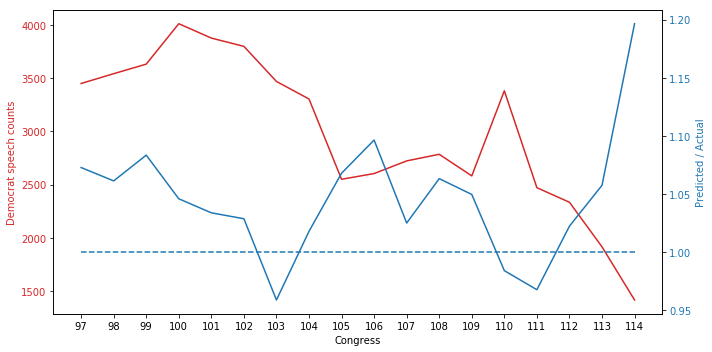

In [61]:
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:red'
ax1.set_xlabel('Congress')
ax1.set_ylabel('Democrat speech counts', color=color)
ax1.plot(congress_df.Congress_, congress_df.Party_dummy_sum, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Predicted / Actual', color=color)  # we already handled the x-label with ax1
ax2.plot(congress_df.Congress_, congress_df.Prediction_balance, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2.hlines(y=1,xmin=97,xmax=114, color=color, linestyles='dashed')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.xticks(range(97,115))
plt.show()